In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import lightgbm as lgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
import warnings
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/umojahack-2023-africa-carbon-dioxide/Train(2).csv')
test = pd.read_csv('/kaggle/input/umojahack-2023-africa-carbon-dioxide/Test(3).csv')
ID = test.ID_LAT_LON_YEAR_WEEK

In [9]:
feature = ['NitrogenDioxide_NO2_column_number_density','Cloud_surface_albedo','NitrogenDioxide_tropospheric_NO2_column_number_density','SulphurDioxide_SO2_column_number_density_15km','UvAerosolIndex_sensor_altitude','Ozone_O3_slant_column_number_density','NitrogenDioxide_absorbing_aerosol_index','Formaldehyde_HCHO_slant_column_number_density','CarbonMonoxide_cloud_height','Ozone_O3_column_number_density_amf','NitrogenDioxide_tropopause_pressure','NitrogenDioxide_cloud_fraction','NitrogenDioxide_sensor_azimuth_angle','Ozone_O3_column_number_density','CarbonMonoxide_sensor_altitude','CarbonMonoxide_solar_azimuth_angle','Cloud_cloud_fraction', 'SulphurDioxide_SO2_column_number_density', 'UvAerosolIndex_solar_azimuth_angle', 'SulphurDioxide_SO2_slant_column_number_density', 'SulphurDioxide_sensor_azimuth_angle', 'UvAerosolIndex_absorbing_aerosol_index', 'SulphurDioxide_cloud_fraction', 'Ozone_cloud_fraction', 'Cloud_solar_azimuth_angle', 'Formaldehyde_cloud_fraction', 'SulphurDioxide_sensor_zenith_angle', 'Ozone_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 'SulphurDioxide_SO2_column_number_density_amf', 'NitrogenDioxide_sensor_zenith_angle', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 'Cloud_cloud_base_pressure', 'NitrogenDioxide_sensor_altitude', 'Cloud_solar_zenith_angle', 'Ozone_O3_effective_temperature', 'Formaldehyde_tropospheric_HCHO_column_number_density', 'CarbonMonoxide_sensor_zenith_angle', 'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth', 'Formaldehyde_tropospheric_HCHO_column_number_density_amf', 'NitrogenDioxide_NO2_slant_column_number_density', 'Ozone_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'Cloud_cloud_top_pressure', 'CarbonMonoxide_sensor_azimuth_angle', 'Formaldehyde_solar_azimuth_angle', 'UvAerosolIndex_sensor_azimuth_angle', 'Formaldehyde_sensor_azimuth_angle', 'Formaldehyde_sensor_zenith_angle', 'Formaldehyde_solar_zenith_angle', 'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle', 'UvAerosolIndex_solar_zenith_angle', 'UvAerosolIndex_sensor_zenith_angle', 'CarbonMonoxide_CO_column_number_density', 'NitrogenDioxide_solar_azimuth_angle']

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74005 entries, 0 to 74004
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      74005 non-null  object 
 1   latitude                                                  74005 non-null  float64
 2   longitude                                                 74005 non-null  float64
 3   year                                                      74005 non-null  int64  
 4   week_no                                                   74005 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  72075 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              72075 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            72075 non-null  float64
 8   SulphurDioxide_c

In [6]:
train.shape, test.shape

((74005, 76), (28085, 75))

In [7]:
#missing data percentage (Train Data)
print('missing in train and test:')
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_train= pd.concat([total, percent_2], axis=1, keys=['train_missing', '%'])

#missing data percentage (test Data)
total = test.isnull().sum().sort_values(ascending=False)
percent_1 = test.isnull().sum()/test.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent_2], axis=1, keys=['test missing', '%'])

missing_train_test = pd.concat([missing_data_train, missing_data_test], axis=1)
missing_train_test[:20]


missing in train and test:


,train_missing,%,test missing,%
UvAerosolLayerHeight_solar_azimuth_angle,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_solar_zenith_angle,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_aerosol_pressure,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_aerosol_optical_depth,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_sensor_zenith_angle,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_sensor_azimuth_angle,69027,93.3,26255.0,93.5
UvAerosolLayerHeight_aerosol_height,69027,93.3,26255.0,93.5
Cloud_cloud_optical_depth,2724,3.7,1133.0,4.0
Cloud_sensor_zenith_angle,2724,3.7,1133.0,4.0
Cloud_cloud_fraction,2724,3.7,1133.0,4.0


# ***Droped 90% missing Value***

In [3]:
col = ['UvAerosolLayerHeight_solar_azimuth_angle','UvAerosolLayerHeight_solar_zenith_angle',
       'UvAerosolLayerHeight_aerosol_pressure','UvAerosolLayerHeight_aerosol_optical_depth',
       'UvAerosolLayerHeight_sensor_zenith_angle','UvAerosolLayerHeight_sensor_azimuth_angle',
       'UvAerosolLayerHeight_aerosol_height'
      ]

train.drop(col,axis=1,inplace=True)
test.drop(col,axis=1,inplace=True)

# **Adverisal Validation**

In [15]:
# add the train/test labels
def Adverisal_Validation(train,test,target, droped_columns, gpu=False):
    '''
        check train and test is dectinigution
    '''
    
    train.drop(droped_columns,axis=1,inplace=True)
    test.drop(droped_columns,axis=1,inplace=True)
    train.drop(target,axis=1,inplace=True)
    
# add the train/test labels
    train["AV_label"] = 0
    test["AV_label"]  = 1

    test = test.select_dtypes(include=['number'])
    train = train.select_dtypes(include=['number'])

    # make one big dataset
    data = pd.concat([train, test], axis=0, ignore_index=True)

    # shuffle
    data = data.sample(frac=1)

    X = data.drop(['AV_label'], axis=1)
    y = data['AV_label']

    # our XGBoost parameters
    params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.01,
          'max_depth': 7, }
    XGBdata = xgb.DMatrix(data=X,label=y,enable_categorical=True)

    # perform cross validation with XGBoost
    print('fiting...')
    cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)
    print('AUC result: ',cross_val_results["test-auc-mean"])
    
    return X,y
## get Feature Important from that model


In [16]:
# X,y = Adverisal_Validation(train.copy(),test.copy(),target='emission', droped_columns = ['ID_LAT_LON_YEAR_WEEK'])

# **Feature Important from Adversial Validation**

In [17]:
def xGboost_feature_Important(X,y,gpu=False):
    ## Feature Important from Adevrsaiol validation
    
    classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
    if gpu:classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False, tree_method='gpu_hist')
    classifier.fit(X, y)
    fig, ax = plt.subplots(figsize=(12,6))
    plot_importance(classifier, ax=ax)
    plt.show()

In [18]:
# xGboost_feature_Important(X,y)

# **EDA**

In [4]:
train['Place'] = train['latitude'].astype(str) +'_' +train['longitude'].astype(str)
test['Place']  = test['latitude'].astype(str) +'_' +test['longitude'].astype(str)
train.drop(['latitude','longitude'],axis=1,inplace=True)
test.drop(['latitude','longitude'],axis=1,inplace=True)

# **Preprocessing Data**

In [81]:
def Prerocessing1(train,test,feature,fet_groupby):
    
    #Agregation
    for data in(train,test):
        for fet in feature:
            data[fet+'_min'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.min())
            data[fet+'_max'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.max())
            data[fet+'_mean'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.mean())
            data[fet+'_std'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.std())
            data[fet+'_var'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.var())
            data[fet+'_range'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.min() - x.max())
            data[fet+'_sem'] = data.groupby('Place')[fet].transform(lambda x: x.sem())
            data[fet+'_sum'] = data.groupby('Place')[fet].transform(lambda x: x.sum())

    
   # Date
        
#         print(data)
     # Lag
    
    #Rolling
    
    return train,test

# **DATE**

In [5]:
for df in [train,test]:
    we = df.year*1000 + df.week_no* 10 + 1
    df['date'] = pd.to_datetime(we, format='%Y%W%w')
    df.drop('week_no',axis=1,inplace=True)
#     df.sort_values(by='date',inplace=True)
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['week_year'] = df['date'].dt.week.astype(str) +'-' +df['date'].dt.year.astype(str)
    df['month_year'] = df['date'].dt.month.astype(str) +'-' +df['date'].dt.year.astype(str)

# **Date Defference**

In [6]:
# Add difference between date by place
for df in [train,test]:
    df['date_diff'] = df['date'] - df.groupby('Place')['date'].transform(lambda x: x.min())
    df['date_diff'] = df['date_diff'].dt.days

# **Agregation**

In [15]:
print('train shape',train.shape, 'test shape',test.shape)

train shape (74005, 72) test shape (28085, 71)


In [10]:
def agg(fet_groupby):
    for data in(train,test):
        for fet in feature:
            data[fet_groupby+'_'+fet+'_min'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.min())
            data[fet_groupby+'_'+fet+'_max'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.max())
            data[fet_groupby+'_'+fet+'_mean'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.mean())
            data[fet_groupby+'_'+fet+'_std'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.std())
            data[fet_groupby+'_'+fet+'_var'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.var())
            data[fet_groupby+'_'+fet+'_range'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.min() - x.max())
            data[fet_groupby+'_'+fet+'_sem'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.sem())
            data[fet_groupby+'_'+fet+'_sum'] = data.groupby(fet_groupby)[fet].transform(lambda x: x.sum())
        print('train shape',train.shape, 'test shape',test.shape)

In [11]:
agg_fet = ['Place','month','year','week_year','month_year']
for fet in tqdm(agg_fet):
    agg(fet)

  0%|          | 0/5 [00:00<?, ?it/s]

train shape (74005, 537) test shape (28085, 72)


 20%|██        | 1/5 [01:56<07:47, 116.85s/it]

train shape (74005, 537) test shape (28085, 536)
train shape (74005, 1001) test shape (28085, 536)


 40%|████      | 2/5 [02:05<02:40, 53.47s/it] 

train shape (74005, 1001) test shape (28085, 1000)
train shape (74005, 1465) test shape (28085, 1000)


 60%|██████    | 3/5 [02:13<01:04, 32.33s/it]

train shape (74005, 1465) test shape (28085, 1464)
train shape (74005, 1929) test shape (28085, 1464)


 80%|████████  | 4/5 [03:06<00:40, 40.59s/it]

train shape (74005, 1929) test shape (28085, 1928)
train shape (74005, 2393) test shape (28085, 1928)


100%|██████████| 5/5 [03:26<00:00, 41.32s/it]

train shape (74005, 2393) test shape (28085, 2392)


In [14]:
# agg('date')

# **Mean Encoding**

In [12]:
# define the column i will be used th mean for it
mean_feature = ['year','month_year','week_year','date']
for fet in mean_feature:
    
    mean_enc = train.groupby(fet)['emission'].mean()
    train[fet+'_mean_target_encoding'] = train[fet].map(mean_enc)
    test[fet +'_mean_target_encoding'] = test[fet].map(mean_enc)
print('train shape',train.shape, 'test shape',test.shape)

train shape (74005, 2397) test shape (28085, 2396)


# **Label Encoding**

In [13]:
feats = ['month_year','week_year']
le = LabelEncoder()
for feat in feats:
    for d in [train,test]:
        le.fit(d[feat])
        d[feat] = le.transform(d[feat])
train.drop('date',axis=1,inplace=True)
test.drop('date',axis=1,inplace=True)

# **Rolling**

In [17]:
train.shape, test.shape

((74005, 2396), (28085, 2395))

# **Dublicated Value**

In [14]:
print('before..')
print('train shape',train.shape, 'test shape',test.shape)
for df in [train,test]:
    df.drop_duplicates(inplace=True)
    df = df.loc[:,~df.columns.duplicated()].copy()
print('after..')
print('train shape',train.shape, 'test shape',test.shape)

before..
train shape (74005, 2396) test shape (28085, 2395)
after..
train shape (74005, 2396) test shape (28085, 2395)


# **Modeling**

# **LighGBM**

In [74]:
# custom function to run light gbm model
def lgb_baseline(train_data, y_data, test_data):
    
    X_train, X_test, y_train, y_test = train_test_split(train_data, y_data, test_size=0.3,random_state=42)
    print('X_train :',X_train.shape)
    print('X_test  :', X_test.shape)
    print('y_train :',y_train.shape)
    print('y_test  :',y_test.shape)
    
    print(test.shape)

    params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':5000, 'early_stopping_rounds':200,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7,'random_state':42
             }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], early_stopping_rounds=200, verbose_eval=1000)
    
    pred_test = model.predict(test_data, num_iteration=model.best_iteration)
    return  model, pred_test


In [82]:
X = train.drop(['ID_LAT_LON_YEAR_WEEK','Place','emission'],axis=1)
y = train.emission
test_data = test.drop(['ID_LAT_LON_YEAR_WEEK','Place'],axis=1)
model, pred_test = lgb_baseline(X,y,test_data)

X_train : (51803, 79)
X_test  : (22202, 79)
y_train : (51803,)
y_test  : (22202,)
(28085, 81)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18659
[LightGBM] [Info] Number of data points in the train set: 51803, number of used features: 79
[LightGBM] [Info] Start training from score 7779.681890
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 465.213	valid_1's rmse: 3914.39
[2000]	training's rmse: 261.27	valid_1's rmse: 3891.24
[3000]	training's rmse: 176.233	valid_1's rmse: 3884.24
[4000]	training's rmse: 127.899	valid_1's rmse: 3881.51
[5000]	training's rmse: 97.2248	valid_1's rmse: 3880.16
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 97.2248	valid_1's rmse: 3880.16


In [84]:
sub = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK':ID,'emission':pred_test})
sub.to_csv('overfitting.csv',index=False)

In [89]:
sub.emission.min()

-35953.669436227734

# **Feature Importance**

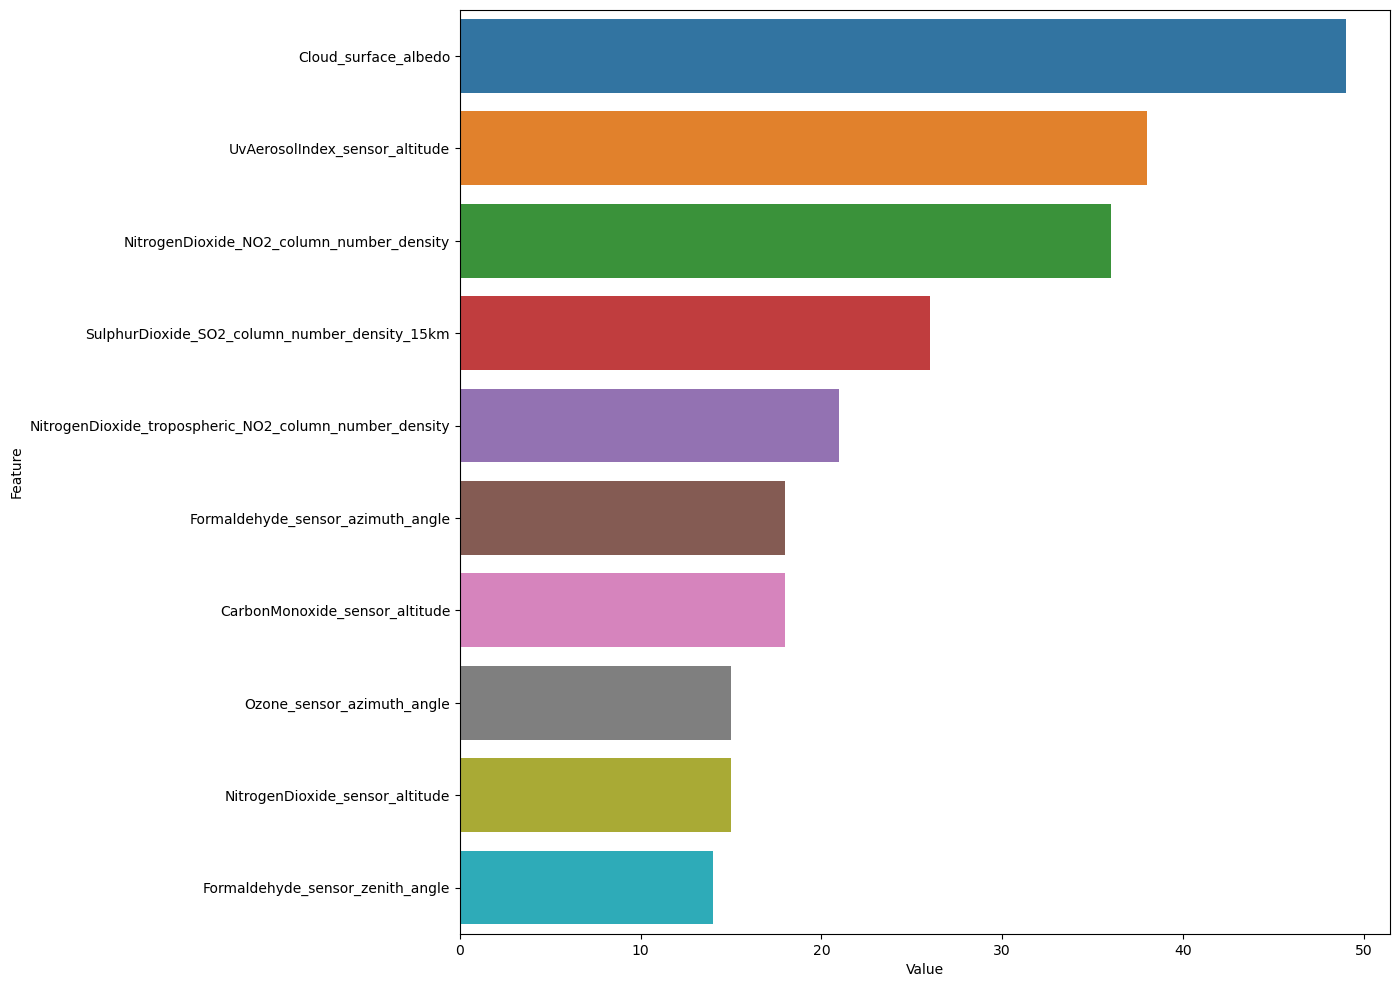

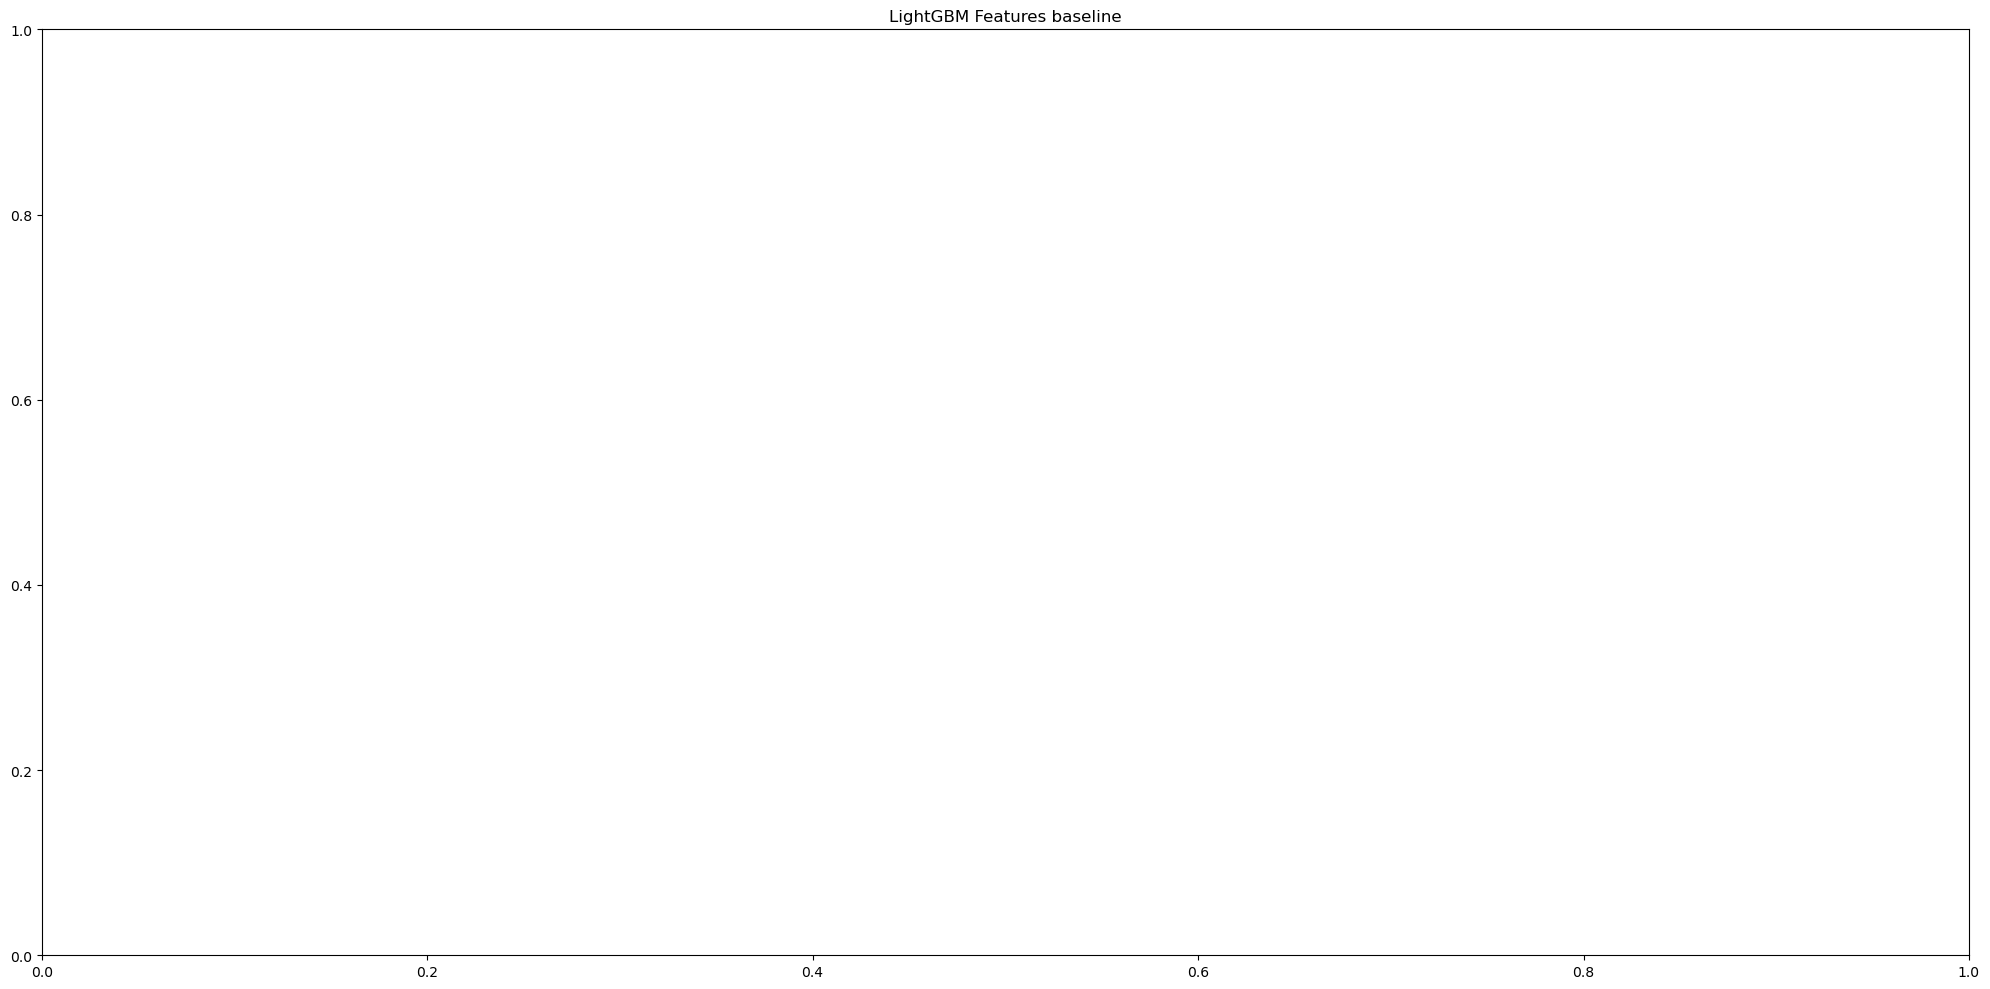

In [214]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), columns=['Value','Feature'])
fig, axis= plt.subplots(figsize=(12,12))
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10],ax=axis)
plt.title('LightGBM Features baseline')
plt.tight_layout()
plt.show()
# get 10 featrure = 


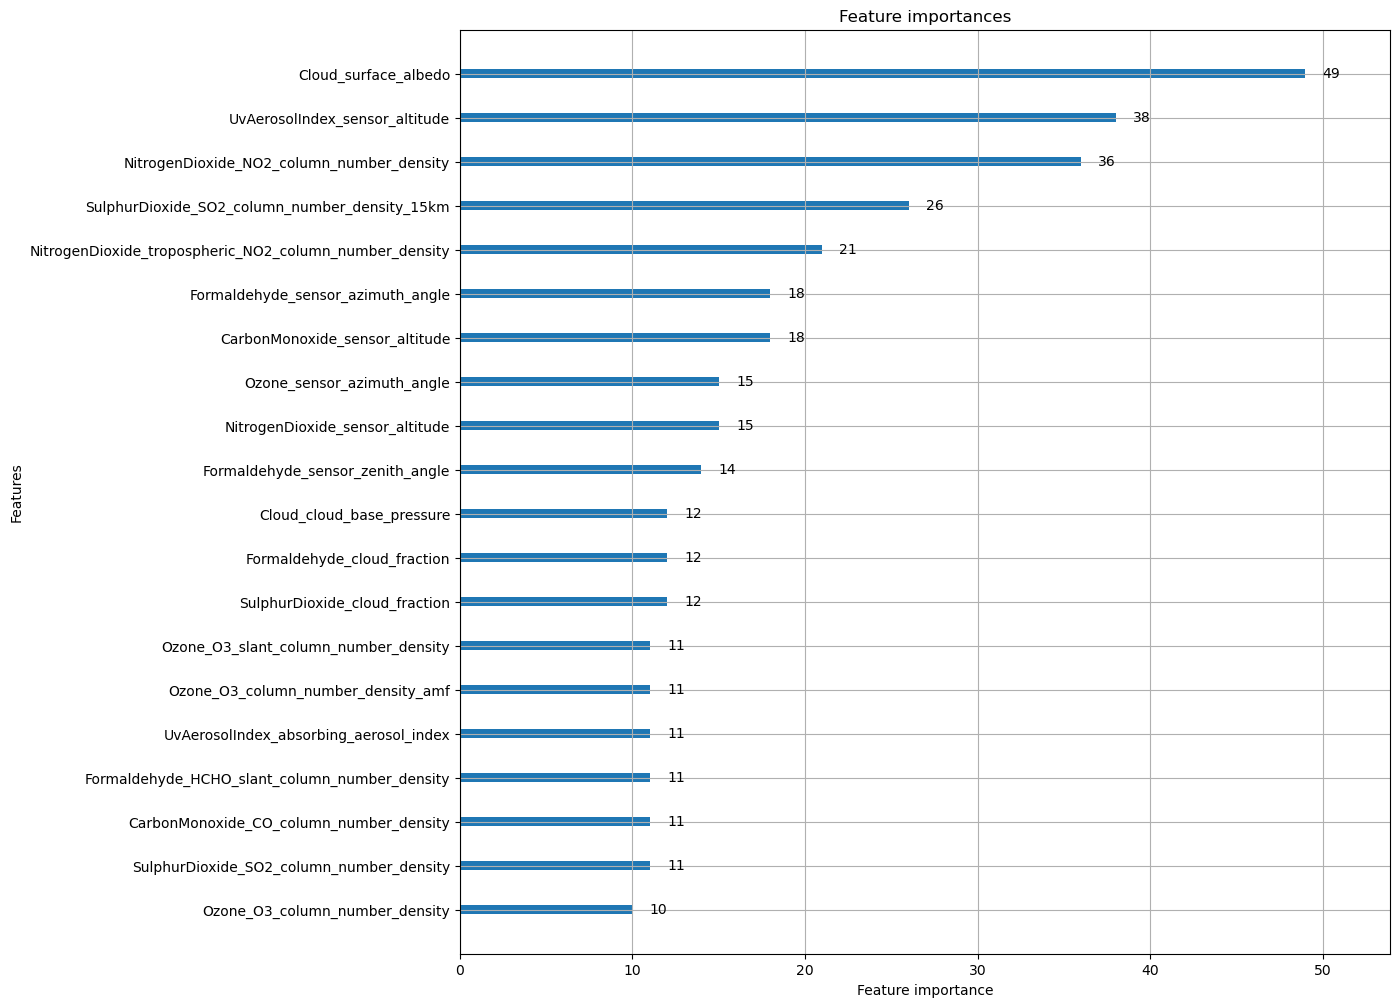

In [212]:
fig, axis= plt.subplots(figsize=(12,12))
lgb.plot_importance(model, max_num_features=20,ax=axis)
plt.title("Feature importances")
plt.show()

In [131]:
cols = feature_imp.sort_values(by="Value", ascending=False).Feature[:30].to_numpy()

In [1]:
Feature = ['NitrogenDioxide_NO2_column_number_density','Cloud_surface_albedo','NitrogenDioxide_tropospheric_NO2_column_number_density','SulphurDioxide_SO2_column_number_density_15km','UvAerosolIndex_sensor_altitude','Ozone_O3_slant_column_number_density','NitrogenDioxide_absorbing_aerosol_index','Formaldehyde_HCHO_slant_column_number_density','CarbonMonoxide_cloud_height','Ozone_O3_column_number_density_amf','NitrogenDioxide_tropopause_pressure','NitrogenDioxide_cloud_fraction','NitrogenDioxide_sensor_azimuth_angle','Ozone_O3_column_number_density','CarbonMonoxide_sensor_altitude','CarbonMonoxide_solar_azimuth_angle','Cloud_cloud_fraction', 'SulphurDioxide_SO2_column_number_density', 'UvAerosolIndex_solar_azimuth_angle', 'SulphurDioxide_SO2_slant_column_number_density', 'SulphurDioxide_sensor_azimuth_angle', 'UvAerosolIndex_absorbing_aerosol_index', 'SulphurDioxide_cloud_fraction', 'Ozone_cloud_fraction', 'Cloud_solar_azimuth_angle', 'Formaldehyde_cloud_fraction', 'SulphurDioxide_sensor_zenith_angle', 'Ozone_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 'SulphurDioxide_SO2_column_number_density_amf', 'NitrogenDioxide_sensor_zenith_angle', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 'Cloud_cloud_base_pressure', 'NitrogenDioxide_sensor_altitude', 'Cloud_solar_zenith_angle', 'Ozone_O3_effective_temperature', 'Formaldehyde_tropospheric_HCHO_column_number_density', 'CarbonMonoxide_sensor_zenith_angle', 'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth', 'Formaldehyde_tropospheric_HCHO_column_number_density_amf', 'NitrogenDioxide_NO2_slant_column_number_density', 'Ozone_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'Cloud_cloud_top_pressure', 'CarbonMonoxide_sensor_azimuth_angle', 'Formaldehyde_solar_azimuth_angle', 'UvAerosolIndex_sensor_azimuth_angle', 'Formaldehyde_sensor_azimuth_angle', 'Formaldehyde_sensor_zenith_angle', 'Formaldehyde_solar_zenith_angle', 'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle', 'UvAerosolIndex_solar_zenith_angle', 'UvAerosolIndex_sensor_zenith_angle', 'CarbonMonoxide_CO_column_number_density', 'NitrogenDioxide_solar_azimuth_angle']

# **Validation `KFold validation`**

In [19]:
# train.dropna(axis=0,inplace=True)

,ID_LAT_LON_YEAR_WEEK,year,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,...,month_year_NitrogenDioxide_solar_azimuth_angle_mean,month_year_NitrogenDioxide_solar_azimuth_angle_std,month_year_NitrogenDioxide_solar_azimuth_angle_var,month_year_NitrogenDioxide_solar_azimuth_angle_range,month_year_NitrogenDioxide_solar_azimuth_angle_sem,month_year_NitrogenDioxide_solar_azimuth_angle_sum,year_mean_target_encoding,month_year_mean_target_encoding,week_year_mean_target_encoding,date_mean_target_encoding
0,ID_-23.73_28.77_2019_1,2019,0.000167,0.713172,0.000102,0.223929,24.939440,56.896198,-89.545030,17.991569,...,-76.477138,8.557702,73.234259,-53.588198,0.227821,-107909.242261,8108.994393,6708.374936,6194.276634,6194.276634
1,ID_-23.73_28.77_2019_2,2019,-0.000155,0.812910,-0.000137,0.080281,16.624162,31.137265,-88.956530,20.223611,...,-76.477138,8.557702,73.234259,-53.588198,0.227821,-107909.242261,8108.994393,6708.374936,6638.668443,6638.668443
2,ID_-23.73_28.77_2019_3,2019,-0.000065,0.860306,-0.000062,0.161050,-13.237244,44.441063,-86.535887,23.737204,...,-76.477138,8.557702,73.234259,-53.588198,0.227821,-107909.242261,8108.994393,6708.374936,6970.633724,6970.633724
3,ID_-23.73_28.77_2019_4,2019,0.000152,0.422284,0.000087,0.046504,-13.534653,61.252501,-80.957632,22.601331,...,-76.477138,8.557702,73.234259,-53.588198,0.227821,-107909.242261,8108.994393,6708.374936,7029.920945,7029.920945
5,ID_-23.73_28.77_2019_6,2019,-0.000133,0.967385,-0.000125,0.249395,-42.746897,28.330738,-74.346451,26.459928,...,-58.373248,11.449502,131.091105,-55.847492,0.311155,-79037.377568,8108.994393,7207.583529,7297.669596,7297.669596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74000,ID_-33.93_25.67_2022_45,2022,0.001192,0.322510,0.000358,0.113889,-95.875226,54.702142,-78.172944,41.535750,...,-78.419887,7.060453,49.849994,-36.400352,0.194554,-103278.990651,8064.874767,7388.731044,7382.976560,7382.976560
74001,ID_-33.93_25.67_2022_46,2022,0.000196,0.393484,0.000081,0.095715,-104.357543,35.734750,-76.344581,37.153098,...,-78.419887,7.060453,49.849994,-36.400352,0.194554,-103278.990651,8064.874767,7388.731044,7248.824811,7248.824811
74002,ID_-33.93_25.67_2022_47,2022,0.000114,0.445499,0.000054,0.007275,76.966014,52.327046,-61.146851,23.905512,...,-78.419887,7.060453,49.849994,-36.400352,0.194554,-103278.990651,8064.874767,7388.731044,7244.307548,7244.307548
74003,ID_-33.93_25.67_2022_48,2022,0.000092,0.377850,0.000035,0.077744,-12.476655,60.298036,-70.081785,30.039554,...,-78.419887,7.060453,49.849994,-36.400352,0.194554,-103278.990651,8064.874767,7388.731044,7678.815258,7678.815258


In [41]:
X = train.drop(['ID_LAT_LON_YEAR_WEEK','Place','emission'],axis=1)
y = train.emission

In [42]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 59204, Test set:14801
Fold:2, Train set: 59204, Test set:14801
Fold:3, Train set: 59204, Test set:14801
Fold:4, Train set: 59204, Test set:14801
Fold:5, Train set: 59204, Test set:14801


In [ ]:
"""
Why we are using '-' sign to calculate RMSE?
ANS: Classification accuracy is reward function, means something you want to maximize. Mean Square Error is loss function, 
means something you want to minimize. Now if we use 'cross_val_score' function then best score(high value) will give worst 
model in case of loss function! There are other sklearn functions which also depends on 'cross_val_score' to select best model by
looking for highest scores, so a design decision was made for 'cross_val_score' to negate the output of all loss function. 
So that when other sklearn function calls 'cross_val_score' those function can always assume that highest score indicate better model.
In short ignore the negative sign and rate the error based on its absolute value.
"""
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [50]:
score = cross_val_score(xgb.XGBRegressor(tree_method='gpu_hist'), X, y, cv= kf, scoring="neg_root_mean_squared_error")
print(f'Scores for each fold: {score}')
score.mean()

Scores for each fold: [-2500.87870219 -1686.85203301 -1942.55329194 -2188.65425445
 -1666.30831753]


-1997.0493198231707

## **Cat boost**

In [15]:
cb_params = {'depth': 7, 'iterations': 7000, 'learning_rate': 0.1,'od_type':'Iter','od_wait':100, 'task_type':'GPU'}
cb = CatBoostRegressor(**cb_params, random_state=42)

In [18]:
X = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','Place'],axis=1).values
y = train.emission.values
test.drop(['ID_LAT_LON_YEAR_WEEK','Place'],axis=1,inplace=True)

preds = pd.Series(0,index=test.index)
scores = []
for train_index, test_index in KFold(n_splits=5).split(X, y):
    X_Train, X_Test = X[train_index], X[test_index]
    y_Train, y_Test = y[train_index], y[test_index]
    
    #Early Stopping for Catboost
    print('fiting...')
    cb.fit(X_Train,y_Train,eval_set=[(X_Test, y_Test)], verbose=400)  
    y_pred = cb.predict(X_Test)
    
    #Print the Score
    scores.append(MSE(y_Test,y_pred, squared=False))
    print(scores[-1])

    #Out-of-Fold Predictions (OOF)
    preds += cb.predict(test) / 5
    print('Seccuss....')
print("\nMean:",np.mean(scores),"\nSTD: ", np.std(scores))

fiting...
0:	learn: 53241.9859295	test: 7987.6719043	best: 7987.6719043 (0)	total: 33.1ms	remaining: 3m 51s
bestTest = 2850.22381
bestIteration = 68
Shrink model to first 69 iterations.
2850.223951681153
Seccuss....
fiting...
0:	learn: 6270.1344763	test: 116698.2980614	best: 116698.2980614 (0)	total: 61.4ms	remaining: 7m 9s
bestTest = 113245.7496
bestIteration = 257
Shrink model to first 258 iterations.
113245.7567278027
Seccuss....
fiting...
0:	learn: 53196.8906906	test: 8510.3200127	best: 8510.3200127 (0)	total: 29.2ms	remaining: 3m 24s
bestTest = 3828.587776
bestIteration = 19
Shrink model to first 20 iterations.
3828.5880346122226
Seccuss....
fiting...
0:	learn: 53132.6935813	test: 9521.4460854	best: 9521.4460854 (0)	total: 29.3ms	remaining: 3m 25s
400:	learn: 454.5019885	test: 6296.9977144	best: 6291.4501359 (332)	total: 11s	remaining: 3m
bestTest = 6291.450136
bestIteration = 332
Shrink model to first 333 iterations.
6291.44982197096
Seccuss....
fiting...
0:	learn: 53112.0385059	

In [19]:
sub = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK':ID,'emission':preds})
sub.to_csv('Eltayb_catboots.csv',index=False)

In [26]:
cb.fit(X,y)

0:	learn: 47703.1196826	total: 29.6ms	remaining: 3m 27s
1:	learn: 43382.9435239	total: 57ms	remaining: 3m 19s
2:	learn: 39305.1153519	total: 85.9ms	remaining: 3m 20s
3:	learn: 35753.3923761	total: 122ms	remaining: 3m 34s
4:	learn: 32406.5794333	total: 150ms	remaining: 3m 30s
5:	learn: 29512.9727854	total: 177ms	remaining: 3m 26s
6:	learn: 26977.6187262	total: 205ms	remaining: 3m 25s
7:	learn: 24605.0449452	total: 236ms	remaining: 3m 26s
8:	learn: 22408.9750064	total: 269ms	remaining: 3m 29s
9:	learn: 20384.4762499	total: 296ms	remaining: 3m 27s
10:	learn: 18607.3984021	total: 323ms	remaining: 3m 25s
11:	learn: 17007.6474542	total: 350ms	remaining: 3m 24s
12:	learn: 15572.1422045	total: 376ms	remaining: 3m 22s
13:	learn: 14271.4245063	total: 403ms	remaining: 3m 21s
14:	learn: 13094.0628442	total: 430ms	remaining: 3m 20s
15:	learn: 12110.1734304	total: 459ms	remaining: 3m 20s
16:	learn: 11196.0103351	total: 485ms	remaining: 3m 19s
17:	learn: 10297.1457327	total: 513ms	remaining: 3m 18s
1

In [28]:
print("\nMean:",np.mean(scores[-1]),"\nSTD: ", np.std(scores))


Mean: 5350.281861410335 
STD:  43482.53179512262


In [29]:
cb.predict(test)

array([ 4547.22821755,  3500.94342125,  3698.93573485, ...,
       11267.0783548 , 11561.31036785,  8759.45706541])

In [33]:
preds2 =cb.predict(test)

In [34]:
sub = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK':ID,'emission':preds2})
sub.to_csv('Eltayb_catboots_full_data.csv',index=False)

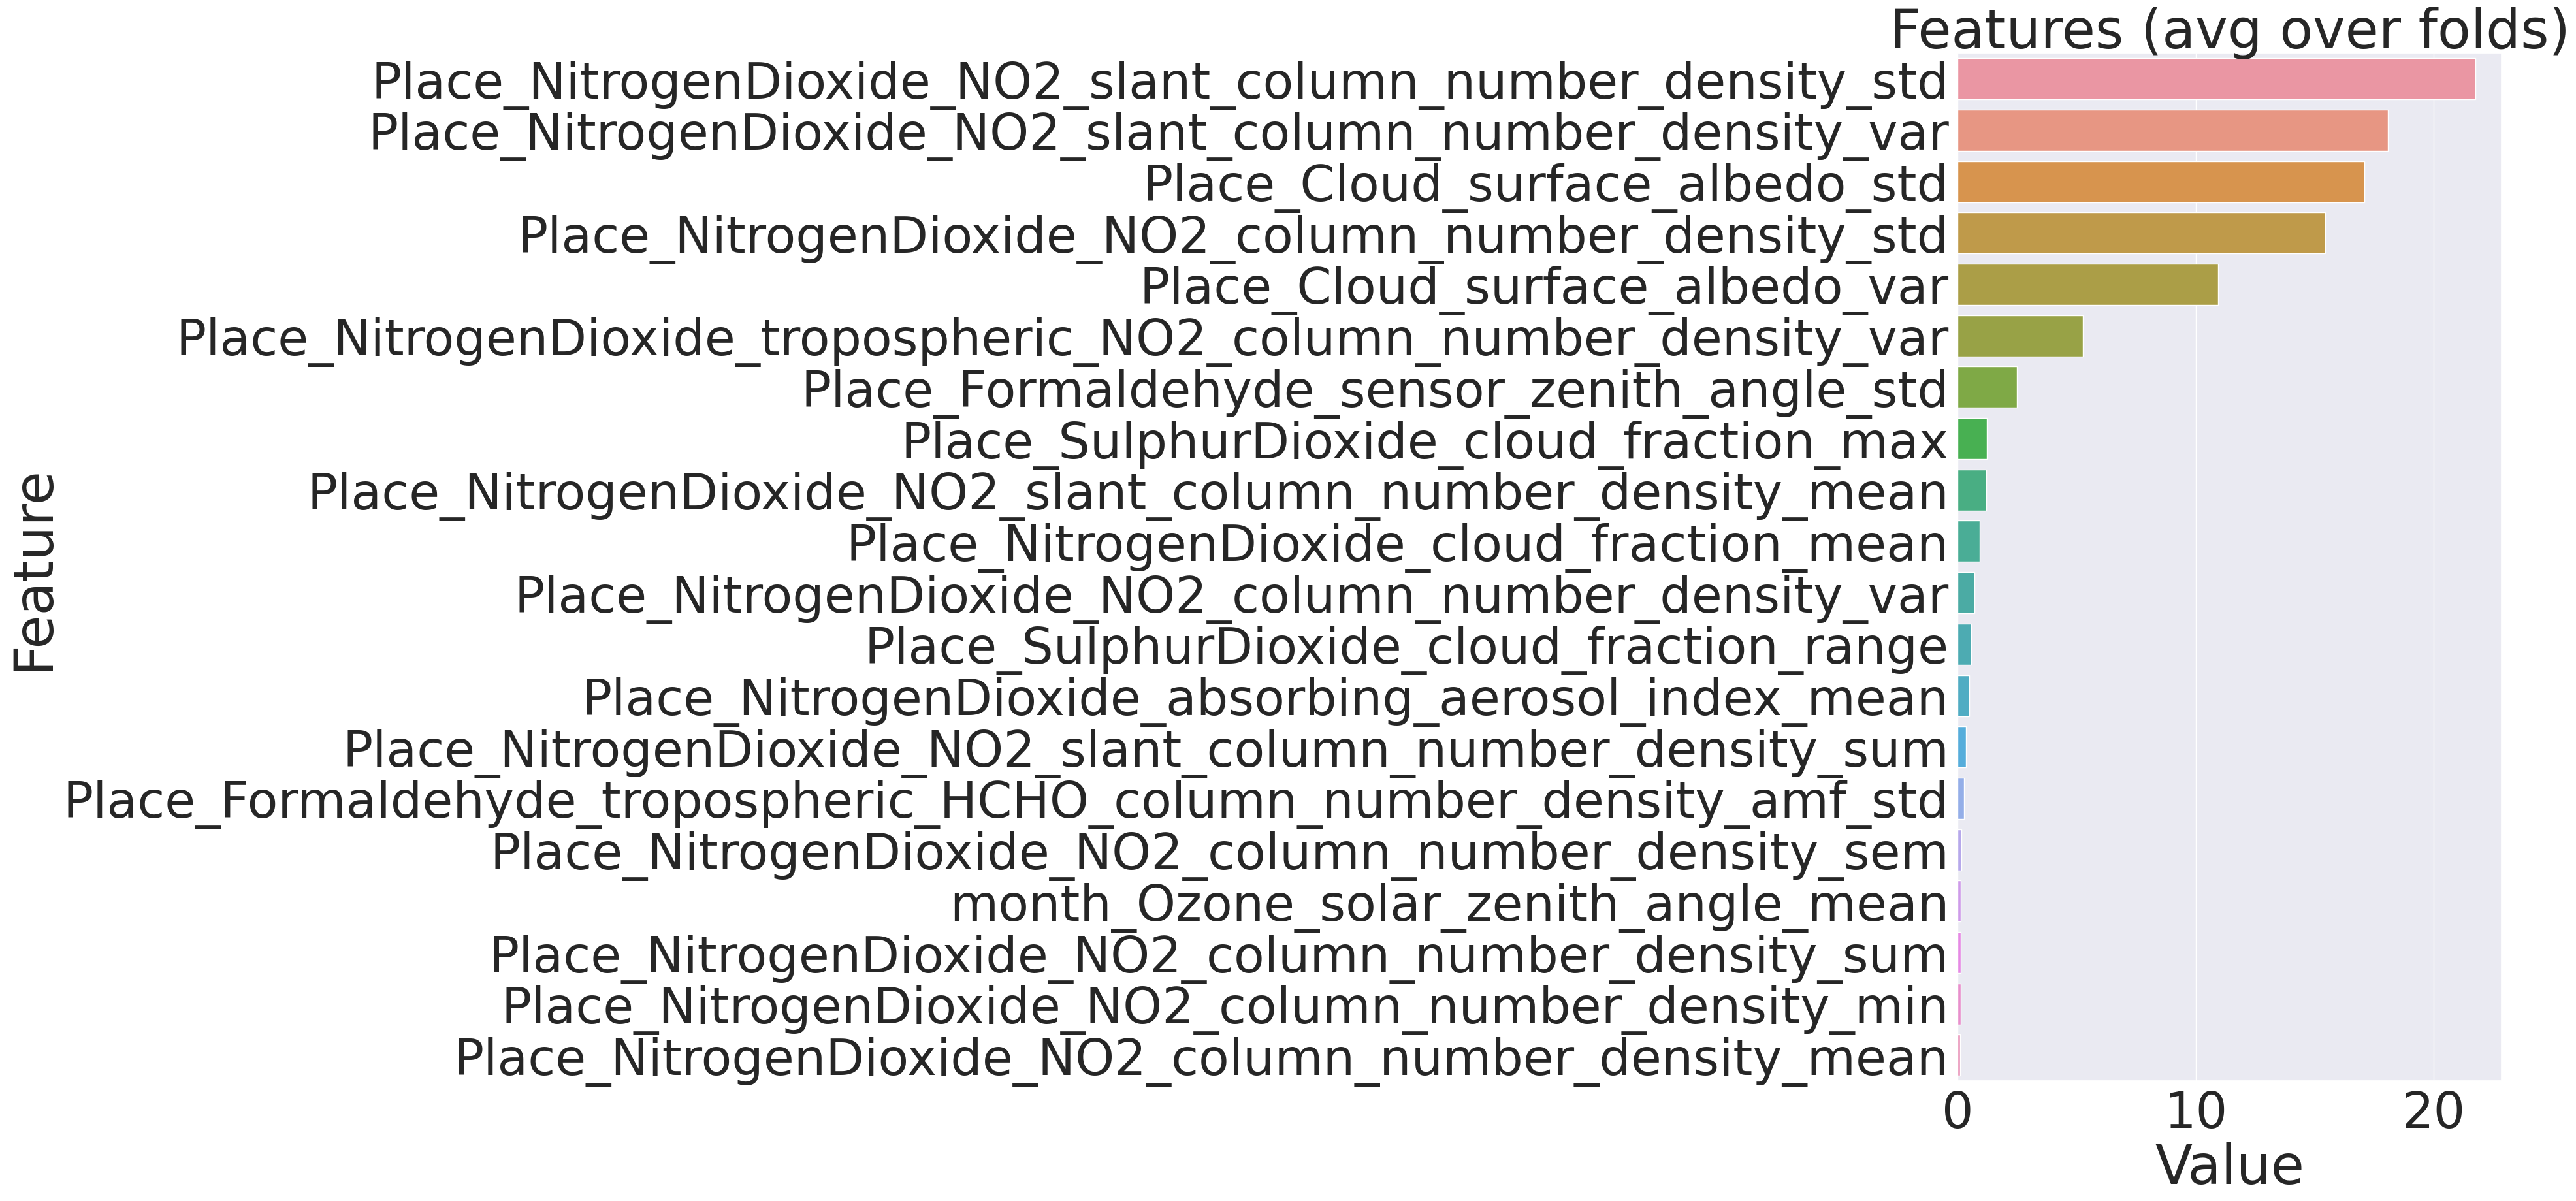

In [37]:
#Plot the Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('importances-01.png')
    plt.show()
    sns.set()

data = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','Place'],axis=1)
plotImp(cb,data)